# Reproject your data
PolarToolkit works exclusively with data projected in either EPSG 3031 or EPSG 3413, for Antarctica and the Arctic/Greenland, respectively. These projections have units of meters and are relative to the poles. If you have your own data which you want to use in PolarToolkit, you may need to reproject it into these projections if its not already in them. Here we'll demonstrate the basics of how to do this.

In [1]:
%load_ext autoreload
%autoreload 2
import os

from polartoolkit import fetch, maps, regions, utils

In [2]:
# set default to southern hemisphere for this notebook
os.environ["POLARTOOLKIT_HEMISPHERE"] = "south"

## Convert a region from lat lon to EPSG
If you have a geographic region in latitude and longitude in the format (lon_min, lon_max, lat_min, lat_max) you can use `region_ll_to_xy` to project it to EPSG polar stereographic, or `region_xy_to_ll` for the opposite.

In [3]:
region_lat_lon = (-104.40, -92.33, -76.42, -73.89)
region_xy = utils.region_ll_to_xy(region_lat_lon)
region_xy

(np.float64(-1760092.1034694898),
 np.float64(-1435602.3038731467),
 np.float64(-438079.2907721378),
 np.float64(-60257.458812579534))

Warning 1: The definition of geographic CRS EPSG:4326 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.
Warning 1: The definition of geographic CRS EPSG:4326 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.
Warning 1: The definition of geographic CRS EPSG:4326 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use officia

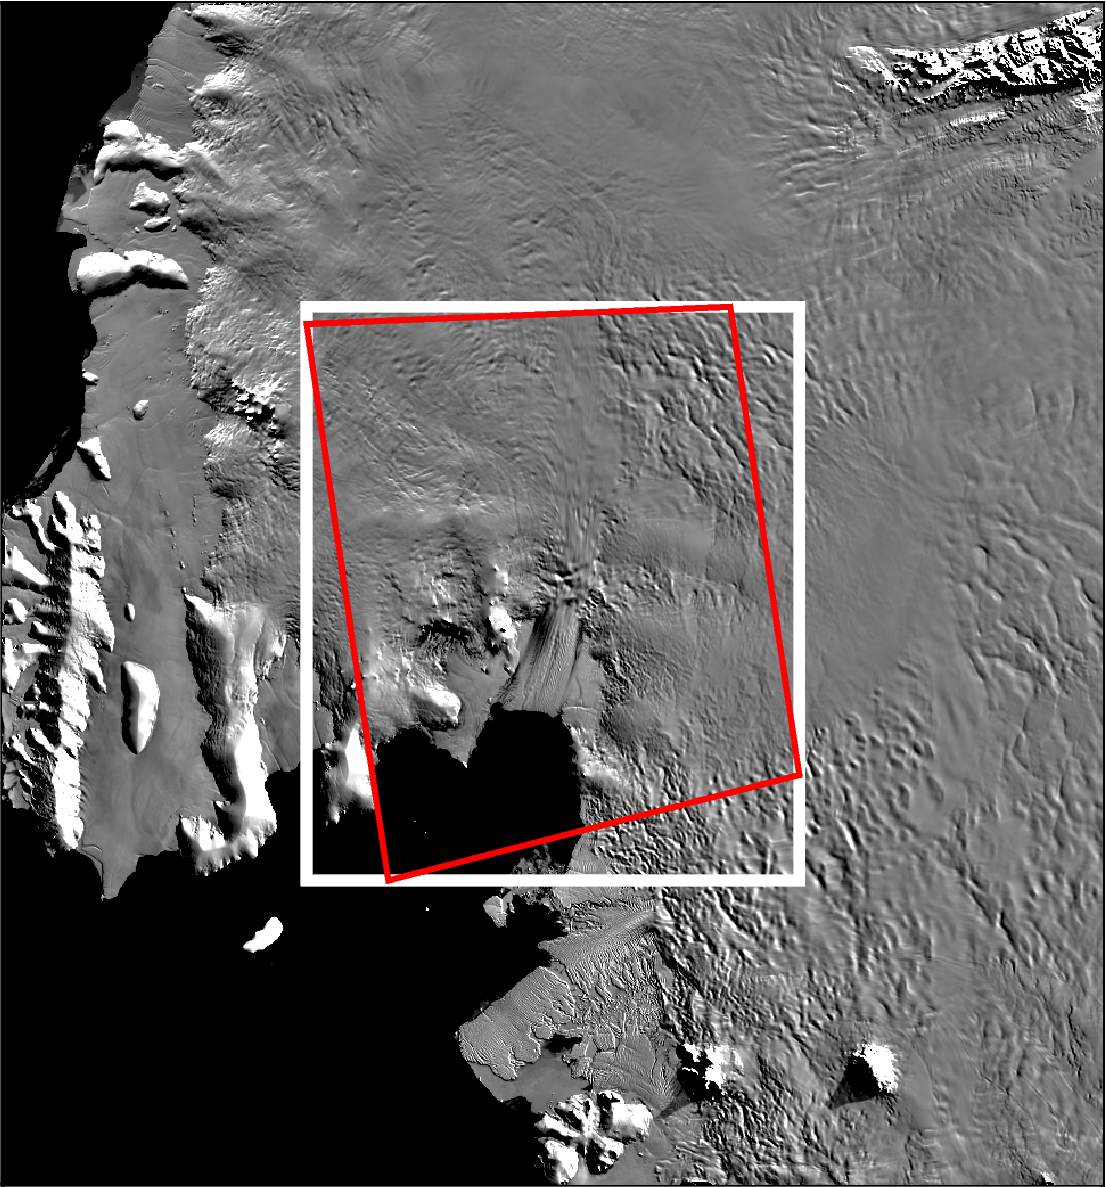

In [ ]:
figure_region = regions.alter_region(region_xy, zoom=-200e3)

fig = maps.plot_grd(
    fetch.modis(),
    modis=True,
    region=figure_region,
)

fig.plot(
    x=[region_xy[0], region_xy[0], region_xy[1], region_xy[1], region_xy[0]],
    y=[region_xy[2], region_xy[3], region_xy[3], region_xy[2], region_xy[2]],
    pen="4p,white",
)


fig.plot(
    projection=utils.set_proj(figure_region)[1],
    region=(*figure_region, "+ue"),  # codespell:ignore ue
    x=[
        region_lat_lon[0],
        region_lat_lon[0],
        region_lat_lon[1],
        region_lat_lon[1],
        region_lat_lon[0],
    ],
    y=[
        region_lat_lon[2],
        region_lat_lon[3],
        region_lat_lon[3],
        region_lat_lon[2],
        region_lat_lon[2],
    ],
    pen="2p,red",
)

fig.show(dpi=200)

The same can be done for coordinate pairs, or pandas dataframes of coordinates.

In [5]:
xy_coords = (-360000, -1100000)

lat_lon_coords = utils.epsg3031_to_latlon(xy_coords)

print(lat_lon_coords)

(-161.87813975209863, -79.37689147851952)


grdimage [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdimage [WARNING]: w reset from -480000 to -480099.229287
grdimage [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdimage [WARNING]: e reset from -240000 to -239848.715345
grdimage [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdimage [WARNING]: s reset from -1220000 to -1220145.03772
grdimage [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdimage [WARNING]: n reset from -980000 to -979905.037199


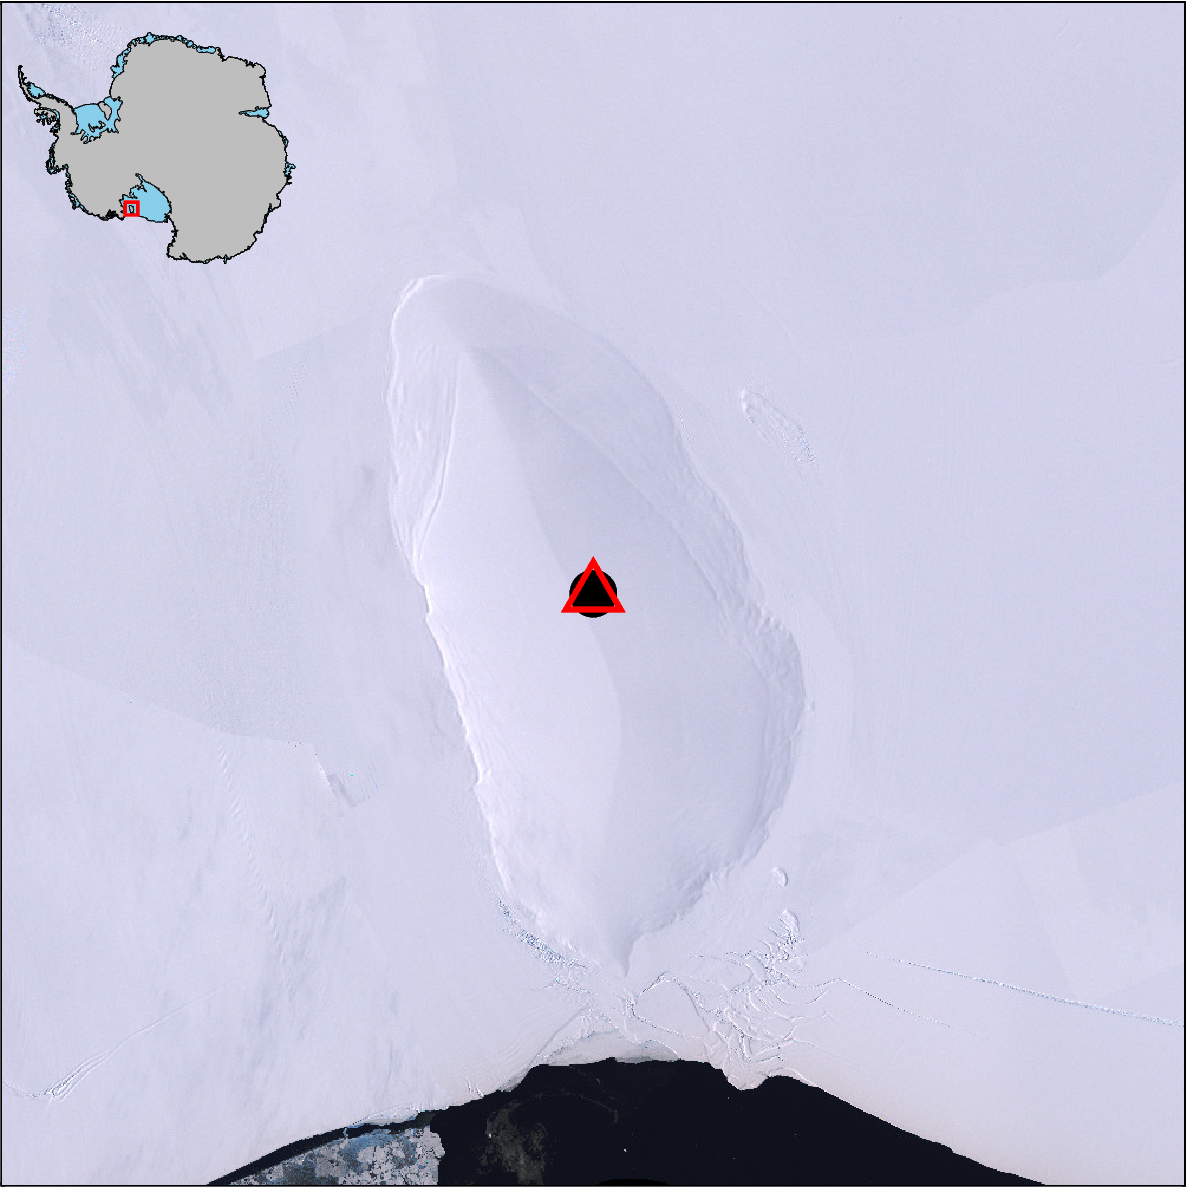

In [ ]:
# plot on map
fig = maps.plot_grd(
    fetch.imagery(),
    region=regions.roosevelt_island,
    colorbar=False,
    inset=True,
)

fig.plot(
    x=xy_coords[0],
    y=xy_coords[1],
    style="c.6c",
    fill="black",
)
fig.plot(
    x=lat_lon_coords[0],
    y=lat_lon_coords[1],
    region=(
        *regions.roosevelt_island,
        "+ue",  # codespell:ignore ue
    ),  # inform region is in meters
    projection=utils.set_proj(regions.roosevelt_island)[1],
    style="t.8c",
    pen="2p,red",
)
fig.show(dpi=200)

If you have gridded data which needs to be reprojected, we recommend the `rioxarray` package with an example shown below.

In [4]:
# fetch a grid which is already in EPSG:3031
grid = fetch.sediment_thickness(
    version="GlobSed", spacing=10e3, region=regions.roosevelt_island
)

# tell rioxarray what the current projection is
grid = grid.rio.write_crs("EPSG:3031")

# reproject to lat lon
grid_ll = grid.rio.reproject("EPSG:4326", resolution=0.1)

# reproject back to EPSG to see if it worked
grid_xy = grid_ll.rio.reproject("EPSG:3031", resolution=10e3)

grdcut [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdcut [WARNING]: w reset from -480000 to -480085.664741
grdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdcut [WARNING]: e reset from -240000 to -239085.664741
grdcut [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdcut [WARNING]: s reset from -1220000 to -1220914.07311
grdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdcut [WARNING]: n reset from -980000 to -979914.07311
grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.


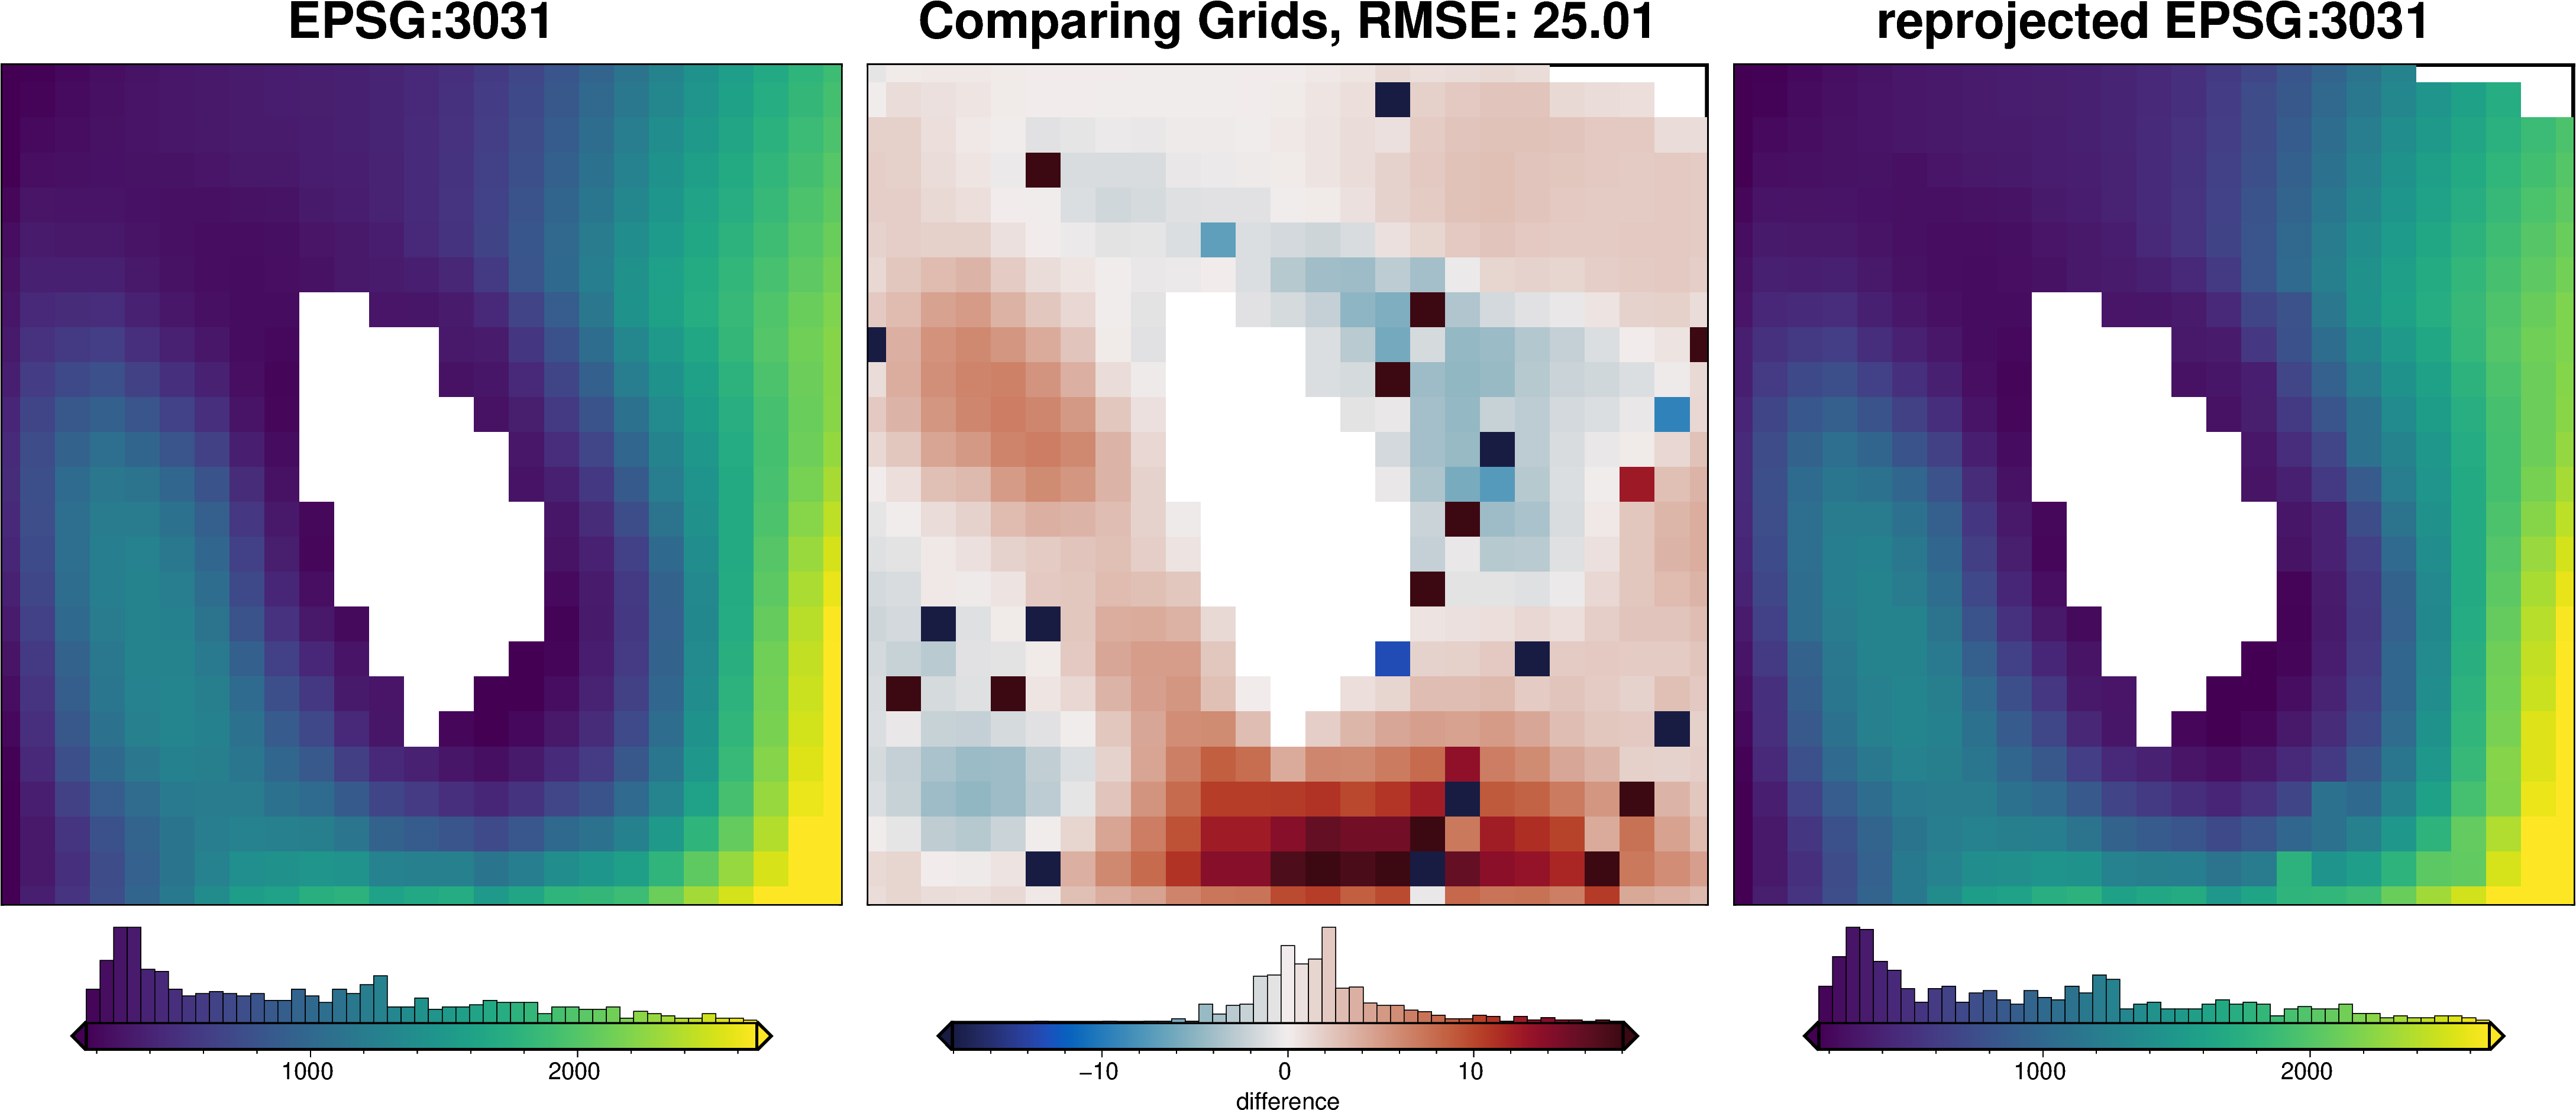

In [5]:
_ = utils.grd_compare(
    grid,
    grid_xy,
    hist=True,
    robust=True,
    grid1_name="EPSG:3031",
    grid2_name="reprojected EPSG:3031",
)